# View the multi-stage image  processing from Selected visits in LSSTComCamSim

- author Sylvie Dagoret-Campagne
- creation date 2024-05-16
- last update 2024-05-16
- affiliation : IJCLab
- kernel : **w_2024_16**


 
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
import matplotlib.gridspec as gridspec
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
import gc

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

### import rubinsimphot

In [8]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [9]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [10]:
import sys
sys.path.append('../lib')
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


In [11]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [12]:
from getObsAtmo import ObsAtmo
emul_atm = ObsAtmo()
WL = emul_atm.GetWL()

LSST site name validated as LSST observatory


In [13]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [14]:
all_Sigb = {}

for index,f in enumerate(filter_tagnames): 
    wl = pc.bandpass_inst[f].wavelen
    tr = pc.bandpass_inst[f].sb
    Sigb = np.trapz(tr/wl,wl)
    all_Sigb[f] = Sigb 
pd.DataFrame(all_Sigb, index=['Sigmab']).round(4)

,u,g,r,i,z,y
Sigmab,0.058,0.1544,0.1157,0.0855,0.0579,0.0309


### Import statements that we will need later

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [15]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection2
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
NDET = 9
suptitle=  collectionStr

tract = 9880 # mostly for light-curves
detector = 0
band = 'g'

suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [16]:
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [17]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [18]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

$$
m_{AB} = -2.5 \log_{10}(F_\nu(nJ) + 31.4
$$


Proof
$$
m_{AB} = -2.5 \log_{10}\left(\frac{F_\nu}{1nJ}\right) - 2.5 \log_{10} \frac{1nJ}{3616 Jy}
$$


$$
m_{AB} = -2.5 \log_{10}\left(\frac{F_\nu}{1nJ}\right) + 2.5 \log_{10} (3616 \times 10^9)
$$

$$
m_{AB} = -2.5 \log_{10}\left(\frac{F_\nu}{1nJ}\right) + 31.4
$$

In [19]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [20]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)


In [21]:
tWCS

FITS standard SkyWcs:
Sky Origin: (249.9173553719, +2.2314049587)
Pixel Origin: (14024, 14024)
Pixel Scale: 0.2 arcsec/pixel

In [22]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

In [23]:
#file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)  
#df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
#cut = (df_myselectedvisits.band == band) &  (df_myselectedvisits.tractID == tract) 
#df = df_myselectedvisits[cut]

In [24]:
if 1:
    # get the csv file produced by stat_on_visits_LSSTAuxtel.ipynb in ../Visits
    file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
    
  
    df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)

    # select the band
    cut = (df_myselectedvisits.band == band) &  (df_myselectedvisits.tractID == tract) & (df_myselectedvisits.detector == detector)
    df_myselectedvisits = df_myselectedvisits[cut]

    #move the visitid as a column not to loose it during the merge 
    df_myselectedvisits.reset_index(inplace=True) 


In [25]:
index = 10
visitId = df_myselectedvisits.iloc[index]['visitId']

Note here:
- zeroPoint is in ABMag relative to a flux of 1 ADU/sec
- skyBg is in ADU 
- skyNoise is in ADU 

In [26]:
df_myselectedvisits.iloc[index]

ccdVisitId     730865991424
visitId       7024040300511
band                      g
detector                  0
ra               249.680108
dec                2.045098
llcra            249.521612
llcdec              2.03574
ulcra            249.673597
ulcdec             2.203663
urcra            249.838624
urcdec             2.054446
lrcra            249.686623
lrcdec             1.886531
ccdVid               130560
Vid                     510
nightObs           20240403
tractID                9880
patchID                 113
zeroPoint          31.34272
airmass            1.349215
skyBg             346.39948
skyNoise           19.30845
expTime                30.0
Name: 10, dtype: object

In [27]:
datasetType = 'postISRCCD'
dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, collections  = collections)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    print("band:", ref.dataId['band'])
    band = ref.dataId['band']
    img= butler.get(ref)
    md = img.getMetadata().toDict()

    list_of_keys = list(md.keys())
    for key in list_of_keys:
        if "CALIB" in key:
            print(key,"::",md[key])
        if "unit" in key or "UNIT" in key:
            print(key,"::",md[key])
        if "gain" in key or "GAIN" in key:
            print(key,"::",md[key])

{instrument: 'LSSTComCamSim', detector: 0, exposure: 7024040300511, band: 'g', day_obs: 20240403, group: '2024-04-04T06:35:35.650', physical_filter: 'g_01'}
band: g
CCDGAIN :: 1.0
BUNIT :: adu
AP0_GAIN :: 0
AP1_GAIN :: 0
LSST CALIB RUN BIAS :: u/jchiang/bias_70240217_w_2024_07/20240218T190659Z
LSST CALIB UUID BIAS :: c8758a62-1447-4015-a033-28964846c76a
LSST CALIB DATE BIAS :: 2024-02-18 11:12:21 PST
LSST CALIB RUN CAMERA :: LSSTComCamSim/calib/DM-43441/unbounded
LSST CALIB UUID CAMERA :: 5526821a-ad9a-4de7-9022-78f430a4ac3a
LSST CALIB DATE CAMERA :: Unknown Unknown
LSST CALIB RUN CCDEXPOSURE :: LSSTComCamSim/raw/all
LSST CALIB UUID CCDEXPOSURE :: 2ca8641b-e7ec-5507-92da-550908780a0a
LSST CALIB DATE CCDEXPOSURE :: Unknown Unknown
LSST CALIB RUN DARK :: u/jchiang/dark_70240217_w_2024_07/20240218T191310Z
LSST CALIB UUID DARK :: 8fe7f02f-69a6-46c8-ae71-704e9ca34afa
LSST CALIB DATE DARK :: 2024-02-18 11:18:17 PST
LSST CALIB RUN FLAT :: u/jchiang/flat_70240217_w_2024_07/20240218T195122Z
LSS

In [28]:
def getvmivmaxfromimg(arr):
    data_flat = arr.flatten()
    med = np.median(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad
    return vmin,vmax

## One postISRCCD

In [29]:
datasetRefs = registry.queryDatasets('postISRCCD', dataId=dataId, collections  = collections)
for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    expo  = butler.get(ref)
    img = expo.getImage()
#wcs = img.getWcs()
#bbox = img.getBBox()
#corners_ra, corners_dec = get_corners_radec(wcs, bbox)
#extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]
vmin,vmax = getvmivmaxfromimg(img.array)

{instrument: 'LSSTComCamSim', detector: 0, exposure: 7024040300511, band: 'g', day_obs: 20240403, group: '2024-04-04T06:35:35.650', physical_filter: 'g_01'}


In [30]:
data_flat = img.array.flatten()
mu = np.mean(data_flat)
med = np.median(data_flat)
std = np.std(data_flat)
sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

textstr = '\n'.join((
r'$\mu=%.2f$ ADU/pix' % (mu, ),
r'$\mathrm{med}=%.2f$ ADU/pix' % (med, ),
r'$\mathrm{RMS}=%.2f$ ADU/pix' % (std, ),
#r'$\mathrm{med}_{calib}=%.2f$ mag/arcsec2' % (convert_fluxtomag(med*expo_photocalibconstant_mean/pixel_scale**2), ),
r'$\sigma=%.2f$ ADU/pix' % (sigMad, ),))
#r'$\sigma_{calib}=%.1f$ mag/arcsec2' % (convert_fluxtomag(sigMad*expo_photocalibconstant_mean/pixel_scale**2), )))

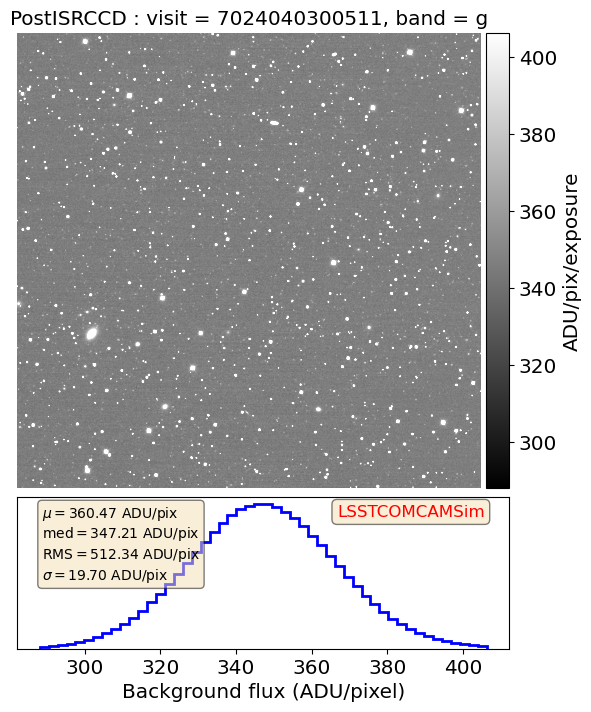

In [31]:
fig = plt.figure(figsize=(5,7),constrained_layout=True)


gs = gridspec.GridSpec(2, 1, figure=fig,height_ratios=[3,1])
ax = fig.add_subplot(gs[0])

im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="gray")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"PostISRCCD : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.set_aspect('equal')
ax.set_axis_off()
cbar = plt.colorbar(im, cax=cax,ax=ax)
cbar.ax.set_ylabel('ADU/pix/exposure')


ax= fig.add_subplot(gs[1])
histdata = ax.hist(data_flat,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax.text(0.65, 0.95, "LSSTCOMCAMSim", transform=ax.transAxes, fontsize=12,color="red",verticalalignment='top', bbox=props)
ax.set_xlabel("Background flux (ADU/pixel)")
ax.get_yaxis().set_visible(False)


## The Calexp

In [39]:
calexp = butler.get('calexp', **dataId,collections=collections)
bkgd  = butler.get('calexpBackground', **dataId,collections=collections)
# get the calibration constant  : expo_photocalibconstant_mean in nJ per ADU. To convert it in AB-Mag : convert_fluxtomag(expo_photocalibconstant_mean) --> zero point
calexp_info = calexp.getInfo()
photocalib = calexp_info.getPhotoCalib()
expo_photocalibconstant_mean = photocalib.getCalibrationMean()

mask = calexp.mask.array
the_mask = np.where(mask==0,1,0)
img = calexp.getImage()
vmin,vmax = getvmivmaxfromimg(img.array)

#data_flat = img.array.flatten()
# here we use the masking
data_flat = (img.array*the_mask).flatten()
data_flat_nozero = data_flat[~(data_flat==0)]
mu = np.mean(data_flat_nozero)
med = np.median(data_flat_nozero)
std = np.std(data_flat_nozero)
sigMad = 1.4826 * np.median(np.fabs(data_flat_nozero - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

textstr = '\n'.join((
r'$photoCalib=%.2f nJ/ADU$' % (expo_photocalibconstant_mean, ),
r'$\mu=%.2f$ ADU/pix' % (mu, ),
r'$\mathrm{med}=%.2f$ ADU/pix' % (med, ),
r'$\mathrm{RMS}=%.2f$ ADU/pix' % (std, ),
#r'$\mathrm{med}_{calib}=%.2f$ mag/arcsec2' % (convert_fluxtomag(med*expo_photocalibconstant_mean/pixel_scale**2), ),
r'$\sigma=%.2f$ ADU/pix' % (sigMad, ),
r'$\sigma_{calib}=%.1f$ mag/arcsec2' % (convert_fluxtomag(sigMad*expo_photocalibconstant_mean/pixel_scale**2), ),))
#r'$photoCalib=%.2f nJ/ADU$' % (expo_photocalibconstant_mean, ),))

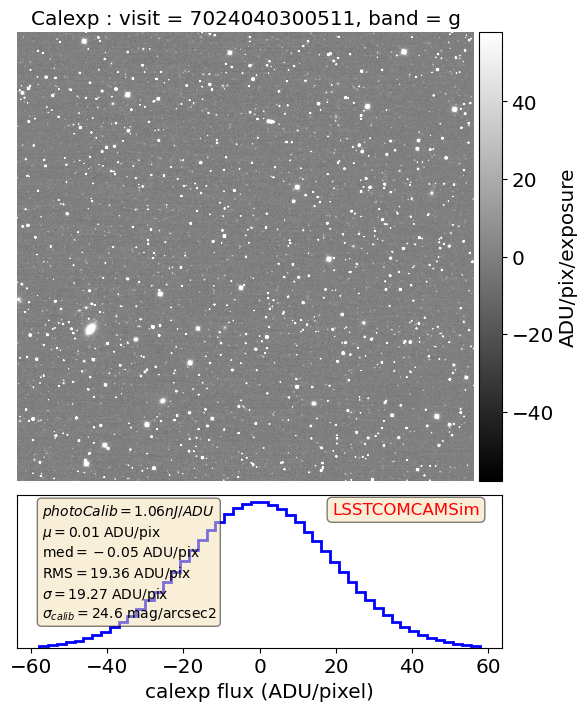

In [41]:
fig = plt.figure(figsize=(5,7),constrained_layout=True)


gs = gridspec.GridSpec(2, 1, figure=fig,height_ratios=[3,1])
ax = fig.add_subplot(gs[0])

im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="gray")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.set_aspect('equal')
ax.set_axis_off()
cbar = plt.colorbar(im, cax=cax,ax=ax)
cbar.ax.set_ylabel('ADU/pix/exposure')


ax= fig.add_subplot(gs[1])
histdata = ax.hist(data_flat_nozero,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax.text(0.65, 0.95, "LSSTCOMCAMSim", transform=ax.transAxes, fontsize=12,color="red",verticalalignment='top', bbox=props)
ax.set_xlabel("calexp flux (ADU/pixel)")
ax.get_yaxis().set_visible(False)

## The Sky Background

In [34]:
img = bkgd.getImage()
vmin,vmax = getvmivmaxfromimg(img.array)

data_flat = img.array.flatten()
mu = np.mean(data_flat)
med = np.median(data_flat)
std = np.std(data_flat)
sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

#textstr = '\n'.join((
#r'$photoCalib=%.2f nJ/ADU$' % (expo_photocalibconstant_mean, ),
#r'$\mu=%.2f$ ADU/pix' % (mu, ),
#r'$\mathrm{med}=%.2f$ ADU/pix' % (med, ),
#r'$\mathrm{RMS}=%.2f$ ADU/pix' % (std, ),
#r'$\mathrm{med}_{calib}=%.2f$ mag/arcsec2' % (convert_fluxtomag(med*expo_photocalibconstant_mean/pixel_scale**2), ),
#r'$\sigma=%.2f$ ADU/pix' % (sigMad, ),
#r'$\sigma_{calib}=%.1f$ mag/pixel' % (convert_fluxtomag(sigMad*expo_photocalibconstant_mean), ),
#r'$photoCalib=%.2f nJ/ADU$' % (expo_photocalibconstant_mean, ),))

textstr = '\n'.join((
r'$photoCalib=%.2f nJ/ADU$' % (expo_photocalibconstant_mean, ),
r'$\mu=%.2f$ ADU/pix' % (mu, ),
r'$\mathrm{med}=%.2f$ ADU/pix' % (med, ),
#r'$\mathrm{RMS}=%.2f$ ADU/pix' % (std, ),
r'$\mathrm{med}_{calib}=%.2f$ mag/arcsec2' % (convert_fluxtomag(med*expo_photocalibconstant_mean/pixel_scale**2), ),
r'$\sigma=%.2f$ ADU/pix' % (sigMad, ),
r'$\sigma_{calib}=%.1f$ mag/pixel' % (convert_fluxtomag(sigMad*expo_photocalibconstant_mean), ),
r'$\sigma_{calib}=%.2f$ nJ/pixel' % (expo_photocalibconstant_mean*sigMad, ),))

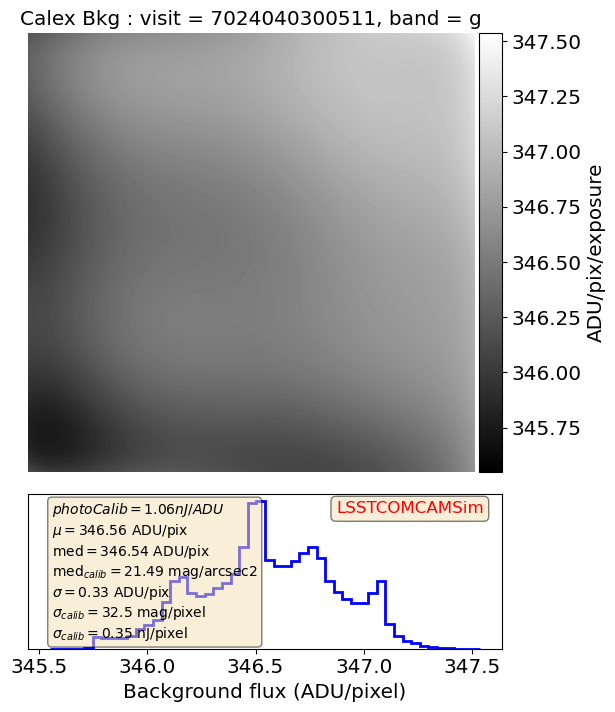

In [35]:
fig = plt.figure(figsize=(5,7),constrained_layout=True)

gs = gridspec.GridSpec(2, 1, figure=fig,height_ratios=[3,1])
ax = fig.add_subplot(gs[0])

im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="gray")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calex Bkg : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.set_aspect('equal')
ax.set_axis_off()
cbar = plt.colorbar(im, cax=cax,ax=ax)
cbar.ax.set_ylabel('ADU/pix/exposure')


ax= fig.add_subplot(gs[1])
histdata = ax.hist(data_flat,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax.text(0.65, 0.95, "LSSTCOMCAMSim", transform=ax.transAxes, fontsize=12,color="red",verticalalignment='top', bbox=props)
ax.set_xlabel("Background flux (ADU/pixel)")
ax.get_yaxis().set_visible(False)